<a href="https://colab.research.google.com/github/LuellaS/testRepo/blob/main/Praca_domowa_Cwicz5_CNN_augmentation_kfold_optuna_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modified version of:
https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb 



### CNN with Image Augmentation (CIFAR10)
images of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. In RGB, 32x32 pixels. 


Naszym zadaniem jest zbudować jak najbardziej wydajny program do klasyfikacji zdjęć uczący się na bardzo małej próbce danych. Proponuję użyć rozmiarów próbek treningowych:

1.    500 obrazków
2.   1000 obrazków
3.   5000 obrazków.
Za każdym razem używamy 10 000 przypadków jako zbioru testowego. Selekcjonujemy z danych tylko trzy klasy obrazków: samochody, ptaki i samoloty (żeby było łatwiej).

To jest tylko szkielet programu - dokonuje klasyfikacji, ale jest daleki od optimum.

**Państwa zadaniem jest:**

1.   Dodać modyfikację obrazów (augmentacja). Jest to zrobione w formie szkieletowej, wariancje parametrów wynoszą zero. Proponuję na początek zmieniać (ta sama zmienna dla dwóch przesunięć i powiększenia):
  *   rotation_range=rotation_range,
  *    width_shift_range=shift_range,
  *    height_shift_range=shift_range,
  *    zoom_range=shift_range  
Oczywiście można potem zwiększyć liczbę optymalizowanych parametrów. 
2. Dodać K-folding np. 5-krotny. Walidację przeprowadamy na 1/5 zbioru treningowego, uczenie na 4/5. Końcowy klasyfikator jest uśrednionym klasyfikatorem z tych pięciu.
3. Dodać optymalizację. Optymalizujemy w pierwszym podejściu trzy zmienne:
  *   rotation_range
  *   shift_range
  *   num_filters - liczba filtrów w warstwie ukrytej.

  Optymalizujemy **bez użycia** danych testowych, tylko posiłkując się danymi walidacyjnym z k-folding. Można optymalizować np. średnią dokładność (accuracy) wszystkich pięciu sieci z k-foldingu. Optymalizację można najpierw prowadzić dla 5 kroków, jak program będzie już działać to dla 30-50 kroków
4. Dla optymalnych parametrów przeprowadzić końcowy trening, narysować "accuracy" dla wszystkich sieci z k-foldingu i zbudować końcowy klasyfikator (średnia z wszystkich klasyfikatorów z k-foldingu).
5. Znaleźć "accuracy" oraz "confusion matrix" dla końcowego klasyfikatora. 
6. Można powtórzyć dla innej liczby obrazków w zbiorze treningowym. 

7. Można optymalizować także:
*  drop_dense2
*  drop_conv2
*  liczbę "bloków" w sieci konwolucyjnej (obecnie trzy)

8. UWAGA: sieć zoptymalizowana dla małej liczby obrazków treningowych może nie być optymalna dla ich dużej liczby

Dużo pracy, ale to kompletny projekt!!!






In [ ]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold

In [ ]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3

# select three classes only and limited number of events

N_TRAIN_EXAMPLES = 1000  # very little!!!!
#N_TEST_EXAMPLES = 100
N_CLASSES = 3

print("Original data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

indices = np.where(y_train < N_CLASSES) # 3 classes only
indices = indices[0]
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]


indices = np.where(y_test < N_CLASSES) # 3 classes only
indices = indices[0]
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]


x_train = x_train[:N_TRAIN_EXAMPLES] # only N_TRAIN_EXAMPLES
y_train = y_train[:N_TRAIN_EXAMPLES]

print(" ")
print("Truncated data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



170500096/170498071 [==============================] - 2s 0us/step
Original data
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
 
Truncated data
(1000, 32, 32, 3)
(1000, 1)
(3000, 32, 32, 3)
(3000, 1)


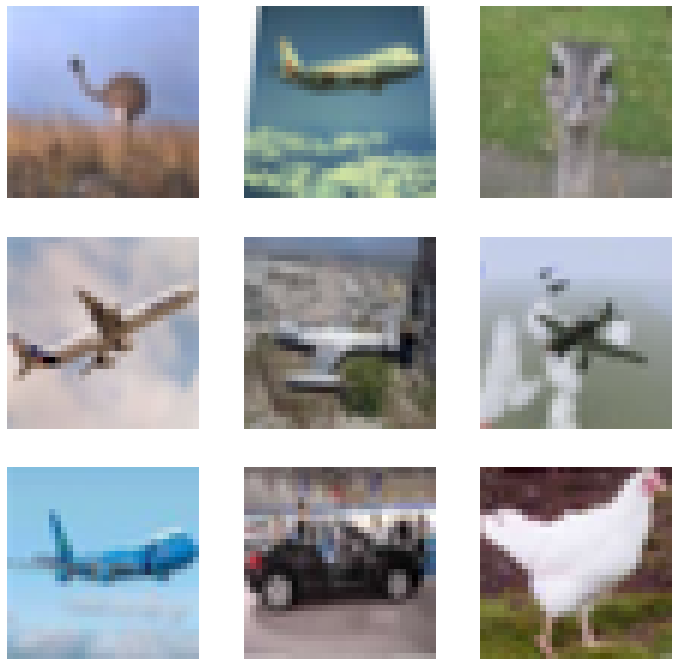

In [ ]:
# save x_test images
xx_test = x_test
yy_test = y_test

fig = plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    #print(x_train[i].shape)
    plt.imshow(x_train[i])
plt.show()

In [ ]:
# set up image augmentation

rotation_range=30
shift_range=0.30

datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
      )  


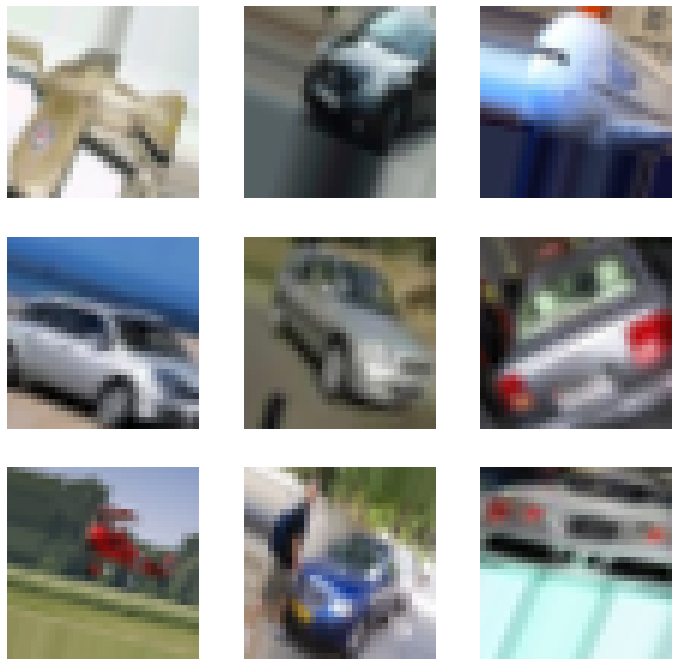

In [ ]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].astype(np.uint8))
         plt.axis('off')
    plt.show()
    break

   

Augmentation of a single image

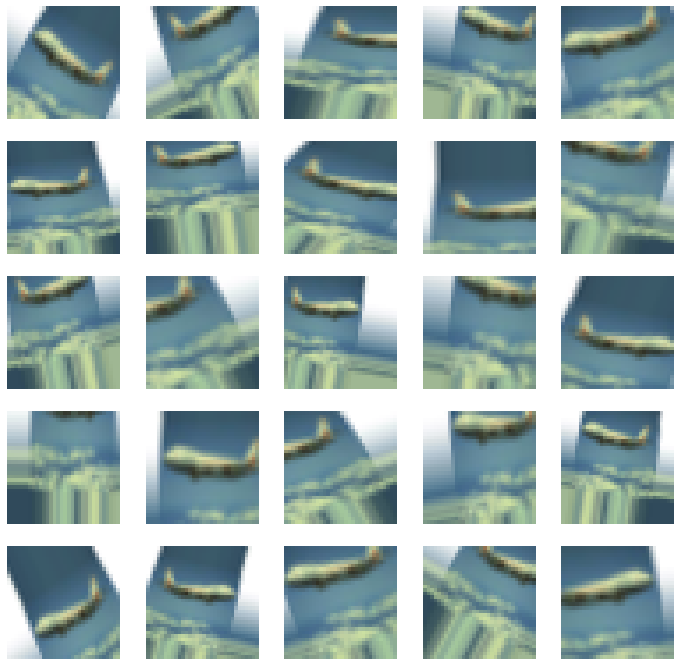

In [ ]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[1:3], y_train[1:3], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].astype(np.uint8))
         plt.axis('off')
         break

plt.show()
    


In [ ]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
#input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1000, 32, 32, 3)
1000 train samples
3000 test samples


In [ ]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [ ]:
 # labels to categorical - output is a vector with length = number of classes
y_train = k.utils.to_categorical(y_train, N_CLASSES)
y_test = k.utils.to_categorical(y_test, N_CLASSES)

# **Optuna & K-FOLDING optimization**





Create convolutional network

In [ ]:
def create_model(num_filters2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=0.5
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

Fit convolutional network

In [ ]:
def fit_model(model2, datagen, x_train, y_train, x_val, y_val):

  # train with image augmentation

  #es = EarlyStopping(
   # monitor="val_accuracy",
    #patience=60,
    #verbose=1
  #)

  history2=model2.fit(datagen.flow(x_train, y_train, batch_size=128),
                     batch_size=128, epochs=150, validation_data=(x_val, y_val), verbose=0)
  return history2, model2

Optimization using optuna or hyperopt

In [ ]:
# OPTUNA

! pip install optuna

import optuna

# or hyperopt
# import hyperopt

     |████████████████████████████████| 266kB 16.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 163kB 28.3MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 133kB 48.6MB/s 
     |████████████████████████████████| 112kB 56.9MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=87e20bc986c7a56746822387f438f1a42fd75ea991316ea651bda8bfbf57e407
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=3a36d93d2f3407c9b59c55b9a0bbd349da0451ca069ae26246f0314331c2f7e0
  Stored in directory: /root/.cache/pip/w

Evaluate model with k-folding

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5, datagen=datagen, num_filters=32):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
      model = create_model(num_filters)
    # select rows for train and test
      trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
      history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
      _, acc = model.evaluate(testX, testY, verbose=0)
      print('> %.3f' % (acc * 100.0))
		# stores scores
      scores.append(acc)
      histories.append(history)
      models.append(model)
  return scores, histories, models
  # Here implement k-folding
  # The next 2 lines should be replaced by k_folding
  # select train_ix as indexes of first 80% of traing events and test_ix as last 20%
  


# **Define objective**

In [ ]:
# here define the hyperopt or optuna objective
#def objective(trial):
def objective(trial):    
    
  shift_range=trial.suggest_uniform('shift_range', .00,0.20)
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  num_filters=32
    
  # set up image augmentation  

  datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
  )
  datagen.fit(x_train)


    #create and evaluate model
  scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters)

  return np.mean(scores)

Run the actual optimization

In [ ]:
# Here you should call the optuna/hyperopt optimization replacing the line below
#objective()
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=14, timeout=12000)


[I 2021-01-09 15:59:55,316] A new study created in memory with name: no-name-4367bad3-1aaa-47be-8d0b-2bc5918bbad5


> 78.000
> 83.500
> 79.000
> 79.000


[I 2021-01-09 16:05:34,042] Trial 0 finished with value: 0.7980000019073487 and parameters: {'shift_range': 0.12135862550957005, 'rotation_range': 24.430531693458917}. Best is trial 0 with value: 0.7980000019073487.


> 79.500
> 77.500
> 89.000
> 78.000
> 82.000


[I 2021-01-09 16:11:01,546] Trial 1 finished with value: 0.8079999804496765 and parameters: {'shift_range': 0.1223160006995101, 'rotation_range': 17.34425293043293}. Best is trial 1 with value: 0.8079999804496765.


> 77.500
> 79.000
> 87.500
> 79.500
> 79.000


[I 2021-01-09 16:16:32,625] Trial 2 finished with value: 0.803000009059906 and parameters: {'shift_range': 0.07722090245482616, 'rotation_range': 2.534622336422916}. Best is trial 1 with value: 0.8079999804496765.


> 76.500
> 82.000
> 89.000
> 86.000
> 73.000


[I 2021-01-09 16:22:08,868] Trial 3 finished with value: 0.8120000004768372 and parameters: {'shift_range': 0.17207151035199522, 'rotation_range': 9.912998397889819}. Best is trial 3 with value: 0.8120000004768372.


> 76.000
> 74.500
> 83.500
> 75.500
> 83.500


[I 2021-01-09 16:27:41,831] Trial 4 finished with value: 0.8009999871253968 and parameters: {'shift_range': 0.1209001878982891, 'rotation_range': 4.514214144640079}. Best is trial 3 with value: 0.8120000004768372.


> 83.500
> 81.500
> 73.000
> 81.000
> 82.500


[I 2021-01-09 16:33:14,361] Trial 5 finished with value: 0.7899999976158142 and parameters: {'shift_range': 0.14930122896604955, 'rotation_range': 20.278916764322442}. Best is trial 3 with value: 0.8120000004768372.


> 77.000
> 80.500
> 82.500
> 74.000
> 79.000


[I 2021-01-09 16:38:48,286] Trial 6 finished with value: 0.7890000104904175 and parameters: {'shift_range': 0.19993144993590498, 'rotation_range': 25.90241582481862}. Best is trial 3 with value: 0.8120000004768372.


> 78.500
> 83.000
> 87.000
> 83.000
> 75.500


[I 2021-01-09 16:44:22,423] Trial 7 finished with value: 0.8159999966621398 and parameters: {'shift_range': 0.13118854236599461, 'rotation_range': 14.291701994425091}. Best is trial 7 with value: 0.8159999966621398.


> 79.500
> 76.500
> 84.000
> 82.500
> 79.500


[I 2021-01-09 16:49:56,708] Trial 8 finished with value: 0.7929999947547912 and parameters: {'shift_range': 0.06576115949983367, 'rotation_range': 10.670729093970504}. Best is trial 7 with value: 0.8159999966621398.


> 74.000
> 81.000
> 82.500
> 83.500
> 79.500


[I 2021-01-09 16:55:25,950] Trial 9 finished with value: 0.8159999966621398 and parameters: {'shift_range': 0.05445916566164486, 'rotation_range': 25.78711682233682}. Best is trial 7 with value: 0.8159999966621398.


> 81.500
> 79.500
> 86.500
> 83.000
> 78.000


[I 2021-01-09 17:01:00,124] Trial 10 finished with value: 0.8139999985694886 and parameters: {'shift_range': 0.19899732386178187, 'rotation_range': 12.733921098341245}. Best is trial 7 with value: 0.8159999966621398.


> 80.000
> 78.000
> 79.000
> 76.500
> 78.500


[I 2021-01-09 17:06:31,023] Trial 11 finished with value: 0.7850000023841858 and parameters: {'shift_range': 0.010176028909410023, 'rotation_range': 28.816718026633882}. Best is trial 7 with value: 0.8159999966621398.


> 80.500
> 79.000
> 87.000
> 79.000
> 76.500


[I 2021-01-09 17:12:00,696] Trial 12 finished with value: 0.8070000052452088 and parameters: {'shift_range': 0.019366525970860686, 'rotation_range': 19.699695915457543}. Best is trial 7 with value: 0.8159999966621398.


> 82.000
> 72.500
> 83.000
> 80.500
> 74.500


[I 2021-01-09 17:17:33,597] Trial 13 finished with value: 0.7850000023841858 and parameters: {'shift_range': 0.05221516163057807, 'rotation_range': 15.365637282703265}. Best is trial 7 with value: 0.8159999966621398.


> 82.000


Print the results

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 14
Best trial:
  Value: 0.8159999966621398
  Params: 
    shift_range: 0.13118854236599461
    rotation_range: 14.291701994425091


In [ ]:
def create_model_2(num_filters2,drop_dense2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=drop_dense2
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model_2(dataX, dataY, n_folds=5, datagen=datagen, num_filters=32, drop_dense2=0.5):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
      model = create_model_2(num_filters,drop_dense2)
    # select rows for train and test
      trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
      history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
      _, acc = model.evaluate(testX, testY, verbose=0)
      print('> %.3f' % (acc * 100.0))
		# stores scores
      scores.append(acc)
      histories.append(history)
      models.append(model)
  return scores, histories, models

In [ ]:
def objective_2(trial):    
    
  rotation_range=trial.params.get('rotation_range')
  shift_range=trial.params.get('shift_range')
  num_filters=trial.suggest_uniform('num_filters', .00,45)
  zoom_range=0.13118854236599461
  drop_dense2=trial.suggest_uniform('drop_dense2', .00,0.9)
    
  # set up image augmentation  

  datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=zoom_range
  )
  datagen.fit(x_train)


    #create and evaluate model
  scores, histories, models = evaluate_model_2(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters,drop_dense2=drop_dense2 )

  return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective_2, n_trials=14, timeout=12000)

[I 2021-01-09 17:22:38,585] A new study created in memory with name: no-name-c125f765-85a4-42e4-bef7-0411d959a9fe


> 80.500
> 85.000
> 75.500
> 73.500


[I 2021-01-09 17:27:29,086] Trial 0 finished with value: 0.7940000057220459 and parameters: {'num_filters': 24.319781603552578, 'drop_dense2': 0.1887301405490489}. Best is trial 0 with value: 0.7940000057220459.


> 82.500
> 77.500
> 86.500
> 78.000
> 80.500


[I 2021-01-09 17:32:24,780] Trial 1 finished with value: 0.8089999914169311 and parameters: {'num_filters': 43.19652164212158, 'drop_dense2': 0.6691768393097975}. Best is trial 1 with value: 0.8089999914169311.


> 82.000
> 79.000
> 85.000
> 79.000
> 78.000


[I 2021-01-09 17:37:09,594] Trial 2 finished with value: 0.7940000057220459 and parameters: {'num_filters': 16.68269534836446, 'drop_dense2': 0.4865986751489921}. Best is trial 1 with value: 0.8089999914169311.


> 76.000
> 74.500
> 79.000
> 80.000
> 75.000


[I 2021-01-09 17:41:51,394] Trial 3 finished with value: 0.7750000119209289 and parameters: {'num_filters': 12.806015423676728, 'drop_dense2': 0.4769630797998876}. Best is trial 1 with value: 0.8089999914169311.


> 79.000
> 81.000
> 85.000
> 79.500
> 81.500


[I 2021-01-09 17:46:44,646] Trial 4 finished with value: 0.8100000023841858 and parameters: {'num_filters': 20.59611950448298, 'drop_dense2': 0.6684509040239552}. Best is trial 4 with value: 0.8100000023841858.


> 78.000
> 77.000
> 79.000
> 76.500
> 74.000


[I 2021-01-09 17:51:37,093] Trial 5 finished with value: 0.775 and parameters: {'num_filters': 9.316934702798475, 'drop_dense2': 0.13953388814443715}. Best is trial 4 with value: 0.8100000023841858.


> 81.000
> 79.500
> 83.000
> 81.500
> 75.500


[I 2021-01-09 17:56:37,888] Trial 6 finished with value: 0.8059999942779541 and parameters: {'num_filters': 39.61015129440311, 'drop_dense2': 0.5492996346025213}. Best is trial 4 with value: 0.8100000023841858.


> 83.500
> 70.500
> 81.000
> 79.000
> 75.000


[I 2021-01-09 18:01:35,663] Trial 7 finished with value: 0.7539999961853028 and parameters: {'num_filters': 4.286846399956838, 'drop_dense2': 0.6302950171815342}. Best is trial 4 with value: 0.8100000023841858.


> 71.500
> 74.000
> 83.000
> 82.000
> 80.500


[I 2021-01-09 18:06:36,982] Trial 8 finished with value: 0.8 and parameters: {'num_filters': 23.18611004073035, 'drop_dense2': 0.19566761751683334}. Best is trial 4 with value: 0.8100000023841858.


> 80.500
> 71.500
> 74.500
> 71.500
> 70.500


[I 2021-01-09 18:11:30,399] Trial 9 finished with value: 0.7109999895095825 and parameters: {'num_filters': 3.498183730569278, 'drop_dense2': 0.05244188531273635}. Best is trial 4 with value: 0.8100000023841858.


> 67.500
> 81.500
> 85.500
> 82.000
> 81.000


[I 2021-01-09 18:16:33,809] Trial 10 finished with value: 0.8240000009536743 and parameters: {'num_filters': 32.40851488628269, 'drop_dense2': 0.8997548641577018}. Best is trial 10 with value: 0.8240000009536743.


> 82.000
> 77.500
> 84.500
> 78.500
> 79.500


[I 2021-01-09 18:21:38,933] Trial 11 finished with value: 0.8110000133514405 and parameters: {'num_filters': 31.004273176054323, 'drop_dense2': 0.8899034752957956}. Best is trial 10 with value: 0.8240000009536743.


> 85.500
> 80.000
> 88.500
> 83.000
> 81.500


[I 2021-01-09 18:26:49,618] Trial 12 finished with value: 0.8259999990463257 and parameters: {'num_filters': 33.7397298824899, 'drop_dense2': 0.8888647681764575}. Best is trial 12 with value: 0.8259999990463257.


> 80.000
> 78.000
> 86.500
> 79.500
> 77.500


[I 2021-01-09 18:31:59,600] Trial 13 finished with value: 0.8 and parameters: {'num_filters': 34.73262064078564, 'drop_dense2': 0.8933890829126006}. Best is trial 12 with value: 0.8259999990463257.


> 78.500


In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 14
Best trial:
  Value: 0.8259999990463257
  Params: 
    num_filters: 33.7397298824899
    drop_dense2: 0.8888647681764575


In [ ]:
def create_model_3(num_filters2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=trial.params.get('drop_dense2')
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

In [ ]:
def evaluate_model_3(dataX, dataY, n_folds=5, datagen=datagen, num_filters=32):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
      model = create_model_3(num_filters)
    # select rows for train and test
      trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
      history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
      _, acc = model.evaluate(testX, testY, verbose=0)
      print('> %.3f' % (acc * 100.0))
		# stores scores
      scores.append(acc)
      histories.append(history)
      models.append(model)
  return scores, histories, models

# **Train with optimized parameters**

In [ ]:
shift_range=shift_range
rotation_range=rotation_range
num_filters=trial.params.get('num_filters')

# here you should get parameters from optimization (the lines below should be updated)
#num_filters = 32
#rotation_range = 5
#shift_range = 0.1


# set up image augmentation
datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
)
datagen.fit(x_train)


#create and evaluate model
scores, histories, models = evaluate_model_3(x_train, y_train, n_folds=5, datagen=datagen)

> 76.000
> 79.500
> 81.000
> 75.500
> 81.500


# **Make plots**

In [ ]:
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['accuracy','val_accuracy'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()

# **Summarize**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



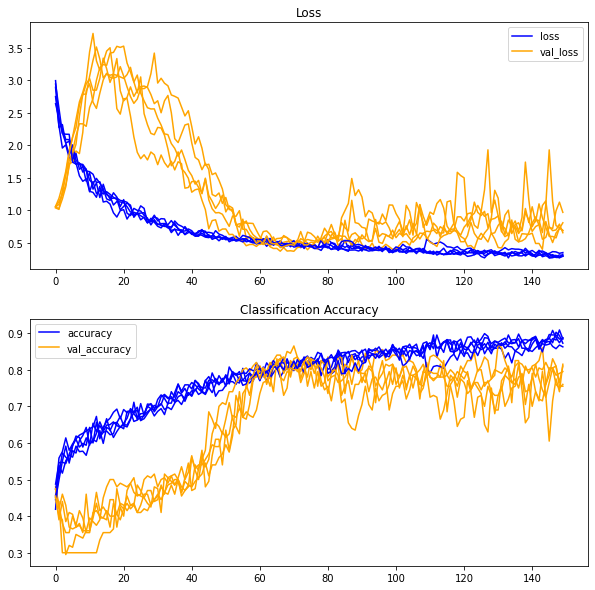

Accuracy: mean=78.700 std=2.502, n=5


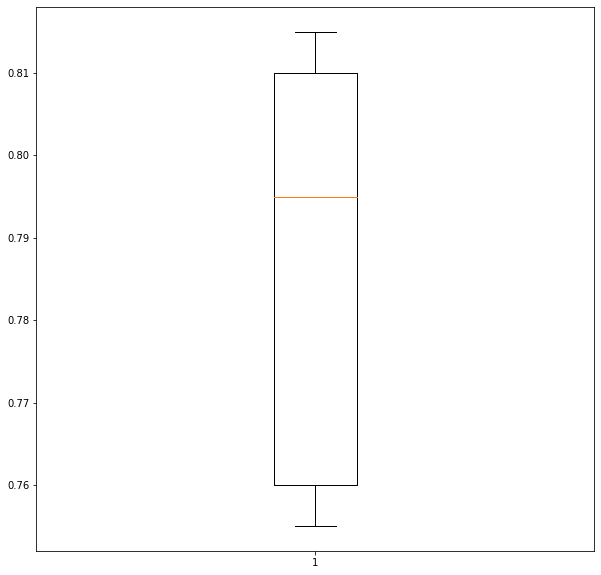

Scores:  [0.7599999904632568, 0.7950000166893005, 0.8100000023841858, 0.7549999952316284, 0.8149999976158142]


In [ ]:
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)

# **Ensamble of networks - build one classifier as an average of n models from variable models**

In [ ]:
# make predictions
yhats = [model.predict(x_test) for model in models]
yhats = np.array(yhats)
#print(yhats)
# sum across ensembles
summed = np.sum(yhats, axis=0)/len(models)
#print(summed)
# argmax across classes
outcomes = np.argmax(summed, axis=1)
#print(outcomes.shape)
#print(outcomes)
# true outcomes
outcomes_true = np.argmax(y_test,axis = 1)
#print(outcomes_true.shape)
#print(outcomes_true)

score = (len(outcomes) - np.count_nonzero(outcomes-outcomes_true))/len(outcomes)

print("Ensamble test accuracy: ",score*100.,"%")


Ensamble test accuracy:  81.46666666666667 %


In [ ]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix


#confusion matrix
cm = confusion_matrix(outcomes_true,outcomes)
print(cm)



[[691 226  83]
 [ 19 973   8]
 [ 97 123 780]]




# **Plot images for the ensamble of models**

In [ ]:
def plot_images2(y_pred, y_pred_prob):
# Names of predicted classes (randomly chosen images)

  import random


  class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  #y_pred = model2.predict_classes(x_test)
  #y_pred_prob = model2.predict(x_test)

  grid_w = 10
  grid_h = 10

  fig = plt.figure(figsize=(20, 40))
  for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    xbar = np.linspace(1, N_CLASSES, num=N_CLASSES)
    plt.bar(xbar,y_pred_prob[i_img])
    plt.axis('off')

  plt.show()


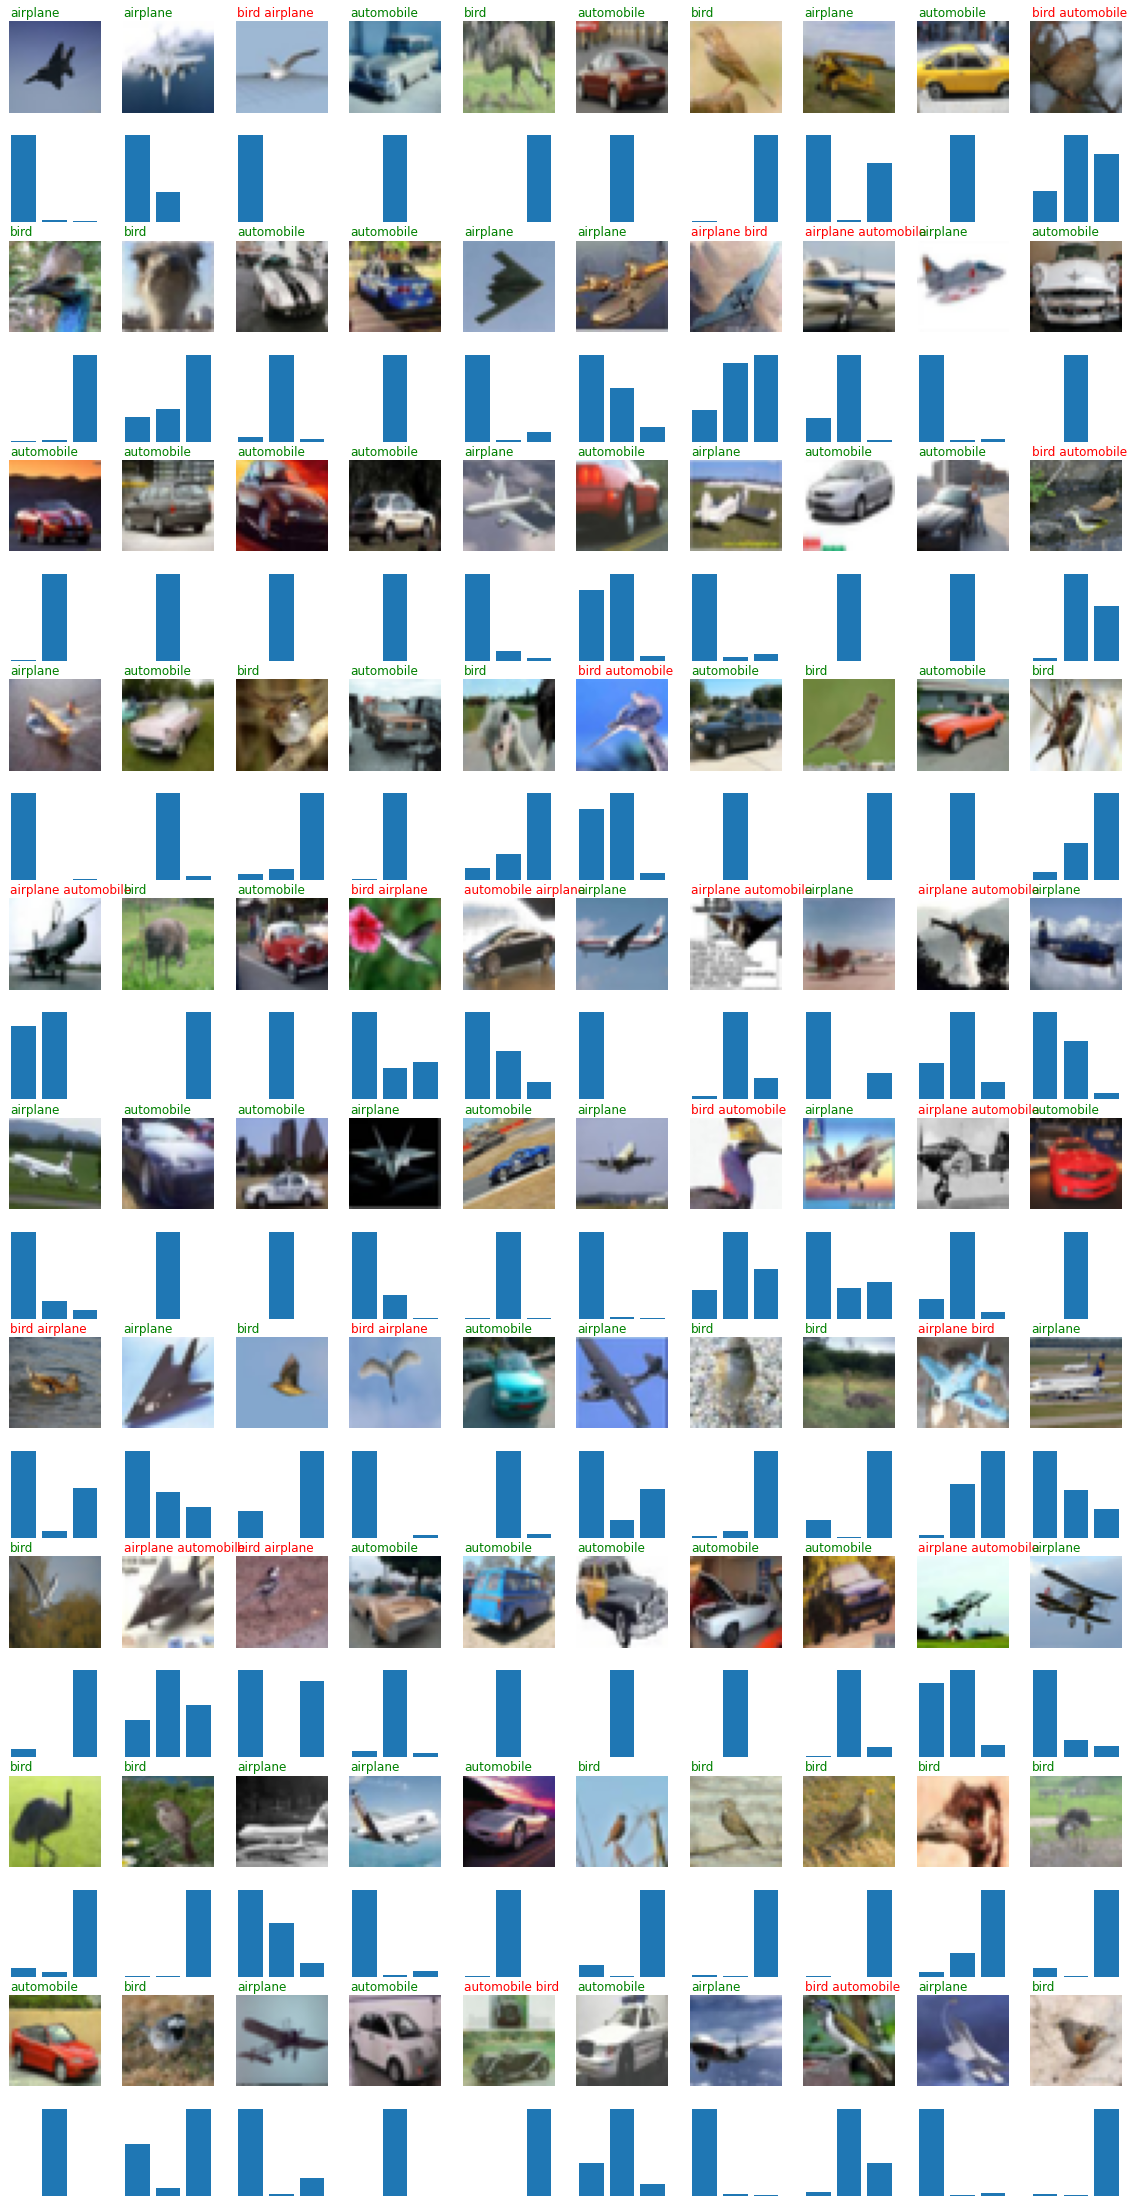

In [ ]:
plot_images2(outcomes,summed)

## Visualizing the Optimization History

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [ ]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

## Visualizing Parameter Relationships

In [ ]:
from optuna.visualization import plot_contour

plot_contour(study)

## Visualizing Individual Parameters

In [ ]:
from optuna.visualization import plot_slice

plot_slice(study)

## Visualizing Parameter Importances

In [ ]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)